<a href="https://colab.research.google.com/github/dahliau/ImplicitGeometricRegularization.Tf/blob/master/TF_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implicit Geometric Regularization for Learning Shapes
This notebook is a tf reproduced code of "Implicit Geometric Regularization for Learning Shapes"
Paper link: https://arxiv.org/abs/2002.10099

Based on pytorch toy example: https://github.com/peisuke/ImplicitGeometricRegularization.pytorch



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
tf.compat.v1.disable_eager_execution()


## 2D toy example

Data is randomly sampled from a circle:

In [32]:
def generate_data(nb_data=128, noise=0.0):
    t = 2 * np.random.rand(nb_data) * np.pi
    r = 1.0 + np.random.randn(nb_data) * noise
    pts = np.stack((r * np.cos(t), r * np.sin(t)), axis=1)
    return pts

Variable initialization functions:

In [33]:
def init_f(shape, dtype=None,size=512):
    # print(shape)
    # ker = np.zeros(shape, dtype=np.float32)
    std = (np.sqrt(2)/np.sqrt(shape[0]))
    ker = np.random.normal(0,std,size=shape)
    return ker

def init_f_out(shape, dtype=None,size=1):
    # print(dtype)
    std = (np.sqrt(np.pi)/np.sqrt(shape[1]))
    ker = np.random.normal(0,std,size=shape)-1
    return ker

Network bulding blocks:

In [34]:
dims=2
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(dims,1)),
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(512-dims, activation='softplus',kernel_initializer=init_f),
])
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(512, activation='softplus',kernel_initializer=init_f),
  tf.keras.layers.Dense(1,kernel_initializer=init_f_out)
])

Build network and compute gradients:

In [35]:
inputs = tf.keras.Input(2)
with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(inputs)  # Since `a.build` has not been called at this point
                           # `a.variables` will return an empty list and the
                           # tape will not be watching anything.
  mid_layer = model1(inputs)
  mid_layer = tf.keras.layers.concatenate([inputs,mid_layer])
  result = model2(mid_layer)


  # tape.gradient(result, model.output)

In [36]:
g = tf.gradients(result,inputs)

Create losses:

Loss prediction: $f(x_{circle})=0$

Eikonal term: $|\nabla f(x)|=1$

In [37]:
#Prediction
outputs_gt = tf.keras.backend.placeholder((None,1))
loss_pred = tf.reduce_mean(tf.abs(outputs_gt-result))

#Eikonal
grad_norm = tf.norm(g[0],axis=1)
loss_grad = tf.reduce_mean((grad_norm-1)**2)

In [38]:
#Total loss
gamma=1.0
loss = loss_pred + gamma* loss_grad

Set optimzer to Adam:

In [39]:
optimizer = tf.compat.v1.train.AdamOptimizer()
grads = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads)

Initialize variables:

In [40]:
tf_compat_v1 = tf.compat.v1
init = tf.compat.v1.global_variables_initializer()
sess = tf_compat_v1.Session()
sess.run(init)

Train:

In [41]:
batch_size=8
X = generate_data(128,0.01)

for i in range(1000):
  for j in range(int(len(X)/batch_size)):
    b_s = j*batch_size
    b_e = (j+1)*batch_size
    x_train = X[b_s:b_e]
    y_train = np.zeros(len(x_train))

    predictions = sess.run([result,train_op,loss_pred,loss_grad,loss],
                                {inputs: x_train,outputs_gt:y_train[:,np.newaxis]})
  if (i%100)==0:
    print('pred',predictions[2],' grad',predictions[3],' total', predictions[4])

pred 63.476284  grad 39.421783  total 102.89807
pred 3.044017  grad 0.010271965  total 3.054289
pred 0.012942992  grad 9.080356e-05  total 0.013033796
pred 0.025641149  grad 0.0017480891  total 0.027389238
pred 0.04726126  grad 0.0043685595  total 0.05162982
pred 0.044715695  grad 0.00044033024  total 0.045156024
pred 0.012715558  grad 0.0006062721  total 0.01332183
pred 0.01596579  grad 9.316415e-05  total 0.016058953
pred 0.017059106  grad 0.001527386  total 0.018586492
pred 0.009568009  grad 0.0013240307  total 0.010892039


## Show results:

In [45]:
resolution=32
l = np.linspace(-1.5,1.5,resolution)
y = np.meshgrid(l,l)
x_test = np.stack([y[0].flatten(),y[1].flatten()],-1)

predictions = sess.run(result,
                              {inputs: x_test})

In [46]:
def plot_data(x, y, v):
    plt.figure(figsize=(12, 6))

    plt.subplot(1,2,1)
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.scatter(x[:,0], x[:,1])
 
    plt.subplot(1,2,2)
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.scatter(y[:,0], y[:,1], c=v, cmap=cm.seismic, vmin=-0.5, vmax=0.5)
    plt.show()

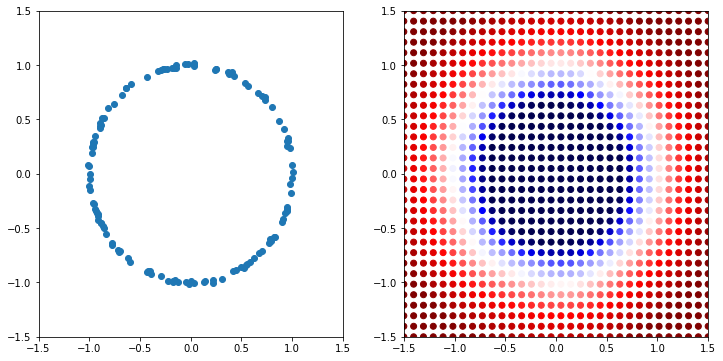

In [47]:
plot_data(X,x_test,predictions)